# Extract time series from Sentinel-5P L2 data

### Single Case Study

In [26]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from geopy.distance import geodesic
import os
import sys
import copy
import mpu
import glob

In [27]:
# import co-ordinates
df = pd.read_csv('coordinates_valid_sampling_pts.csv')
GB_SamplingPoint_107 = df[df['Sampling station ID'] == 'SPO-DK0045A_00010_100']
lon = GB_SamplingPoint_107['Lon']
lat = GB_SamplingPoint_107['Lat']
lat, lon

(16    55.70028
 Name: Lat, dtype: float64,
 16    12.5614
 Name: Lon, dtype: float64)

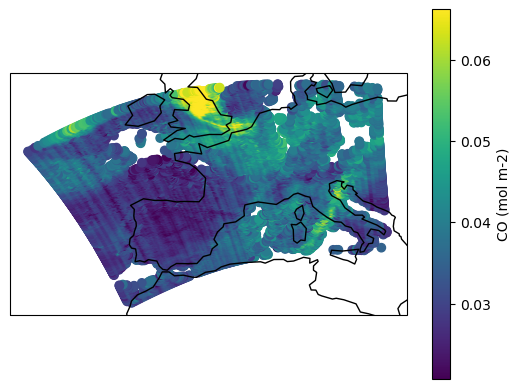

In [28]:
# -- Insert your code -- #
#file = 'S5P_L2_CO_copernicus/S5P_NRTI_L2__CO_____20250601T005409_20250601T005909_39549_03_020800_20250601T023451.nc'  # Name of the level-2 file.
file = 'S5P_L2_CO_copernicus/S5P_NRTI_L2__CO_____20250605T124909_20250605T125409_39613_03_020800_20250605T132435.nc'  # Name of the level-2 file.
s5p_product_name = 'carbonmonoxide_total_column'  # Name of the product in the level-2 file.

# -- End of your code -- #
# Open the .nc file.
s5p_product = xr.open_dataset(file, group='PRODUCT', engine='netcdf4')

# Make the figure have lat lon projection.
s5p_fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Apply coastlines. Resolution can be 10m, 50m or 110m. Higher resolution may be slower.
ax.coastlines(resolution='110m', color='black', linewidth=1)

# Plot the product as a scatter plot. Note that x=lon and y=lat.
plt.scatter(x=s5p_product['longitude'], y=s5p_product['latitude'],
            c=s5p_product[s5p_product_name].squeeze(),
            vmin=np.nanquantile(s5p_product[s5p_product_name], q=0.01),
            vmax=np.nanquantile(s5p_product[s5p_product_name], q=0.99))

# zoom in on the area of interest.
# ax.set_extent([30, 70, -6, 0], crs=ccrs.PlateCarree())

# -- Insert your code -- #
cbar = plt.colorbar()
cbar.set_label('CO (mol m-2)')
# The figure can be saved with .
# s5p_fig.savefig('cool_s5p_fig.png', format='png')

# -- End of your code -- #
plt.show()


In [29]:
# Read latitude, longitude, and CO concentration variables from the NetCDF file
latitudes = s5p_product['latitude'][:][0]
longitudes = s5p_product['longitude'][:][0]
co_concentration = s5p_product['carbonmonoxide_total_column'][:]  # Assuming this is the variable name


In [30]:
# Create arrays of the sampling point with the same shape as latitudes/longitudes
sampling_lat = np.full(latitudes.shape, lat)
sampling_lon = np.full(longitudes.shape, lon)

# Vectorize geodesic
#vectorized_geodesic = np.vectorize(lambda a, b, c, d: geodesic((a, b), (c, d)).km)
#Haversine is the more time efficient
vectorized_haversine = np.vectorize(lambda a, b, c, d: mpu.haversine_distance((a, b), (c, d)))

distances = vectorized_haversine(sampling_lat, sampling_lon, latitudes, longitudes)

In [31]:
min_idx = np.unravel_index(np.argmin(distances), distances.shape)
print("Indices of minimum distance:", min_idx)
print("Min distance:", distances[min_idx])
print(co_concentration[0][min_idx].values)

Indices of minimum distance: (361, 203)
Min distance: 10.19762111676247
0.038556352


Resolutions of sentinel5P for CO is 5.5x7km -> diagonal = 8.9km -> if distance.min() is larger than 8.9km then the swath does not cover the sampling point.

# Automatization

In [34]:
sensors_df = pd.read_csv('coordinates_valid_sampling_pts.csv')
sensors_df = sensors_df[sensors_df['download_success']]
sensors_df = sensors_df.set_index('Sampling station ID')

In [35]:
geo_dir = 'S5P_L2_CO_copernicus'
geo_files = os.listdir(geo_dir)
s5p_product_name = 'carbonmonoxide_total_column'

### Files size and quantity

In [ ]:
# Number of files
len([geo_file for geo_file in geo_files if geo_file!='.DS_Store'])

202

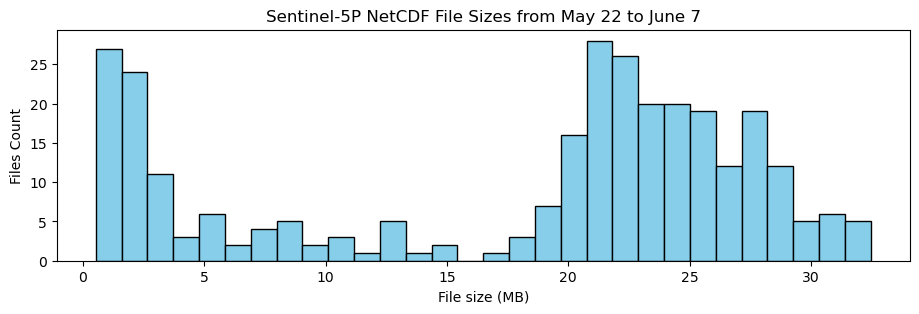

In [60]:
# Get file sizes in MB for all files in geo_dir (excluding .DS_Store)
file_sizes_mb = [
    os.path.getsize(os.path.join(geo_dir, f)) / (1024 * 1024)
    for f in geo_files if f != '.DS_Store'
]

plt.figure(figsize=(11, 3))
plt.hist(file_sizes_mb, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('File size (MB)')
plt.ylabel('Files Count')
plt.title('Sentinel-5P NetCDF File Sizes from May 22 to June 7')
#plt.grid(axis='y')
plt.savefig("file_sizes.jpg", dpi=200, format='png')
plt.show()

In [ ]:
np.median(file_sizes_mb)

21.701178550720215

### Files Count by date

In [33]:
dates = list()
for geo_file in [geo_file for geo_file in geo_files if geo_file!='.DS_Store']:
    date = pd.to_datetime(geo_file.split('_')[10])
    dates.append(date)

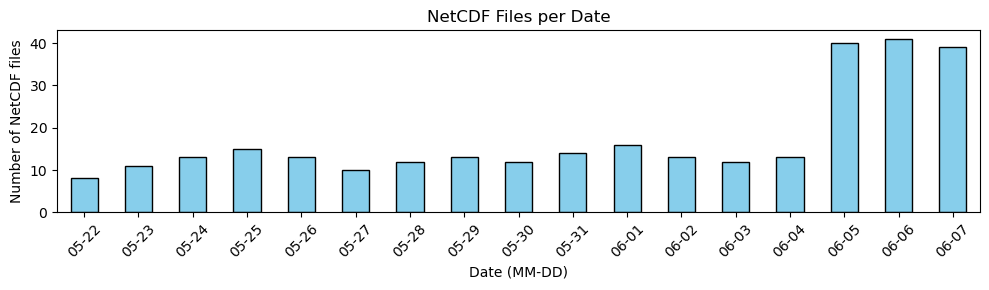

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of records per date (only month and day)
date_counts = (
    pd.Series([d.strftime('%m-%d') for d in dates])  # Convert to MM-DD strings
    .value_counts()
    .sort_index()
)

# Plot
plt.figure(figsize=(10, 3))
date_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Number of NetCDF files')
plt.title('NetCDF Files per Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("file_dates.jpg", dpi=300, format='jpg')
plt.show()


### CO extraction algorithm from NetCDF file according to closest distance to ground sensor

In [37]:
sensors_CO=dict()
for geo_file in [geo_file for geo_file in geo_files if geo_file!='.DS_Store'][:10]:
    #geo_file = 'S5P_NRTI_L2__CO_____20250520T111202_20250520T111702_39385_03_020800_20250520T114600.nc' #Denmark example
    print(f'initiate file {geo_file}')
    #IMPORTING MAP INFORMATION
    try:
        s5p_product = xr.open_dataset(f'{geo_dir}/{geo_file}', group='PRODUCT', engine='netcdf4')
    except:
        print(f'error for f{geo_file}')
        continue
    latitudes = s5p_product['latitude'][:][0]
    longitudes = s5p_product['longitude'][:][0]
    co_concentration = s5p_product['carbonmonoxide_total_column'][:][0]

    succesful_stations=0
    for station in sensors_df.index.unique():
        #IMPORTING EACH SENSOR
        sampling_lon = np.full(longitudes.shape, 
                               sensors_df.loc[station, 'Lon'])
        sampling_lat = np.full(latitudes.shape, 
                               sensors_df.loc[station, 'Lat'])
        
        #Compute distance matrix (geo-map - sensor location)
        #vectorized_geodesic = np.vectorize(lambda a, b, c, d: geodesic((a, b), (c, d)).km)
        #vectorized_euclidean = np.vectorize(lambda a, b, c, d: np.linalg.norm([a - c, b - d]))
        vectorized_haversine = np.vectorize(lambda a, b, c, d: mpu.haversine_distance((a, b), (c, d)))
        distances = vectorized_haversine(sampling_lat, sampling_lon, latitudes, longitudes)
        
        #Obtain the CO (if map is eligible)
        min_idx = np.unravel_index(np.argmin(distances), distances.shape)
        if distances[min_idx]<8.9:
            co_value = co_concentration[min_idx].values
            
            #register it    
            date = pd.to_datetime(geo_file.split('_')[10])
            if station not in sensors_CO.keys():
                sensors_CO[station] = list()
            sensors_CO[station].append((date, co_value))
            succesful_stations+=1
            #print(f'success in {station}')
    print(succesful_stations)
            

initiate file S5P_NRTI_L2__CO_____20250526T105909_20250526T110409_39470_03_020800_20250526T113247.nc
2
initiate file S5P_NRTI_L2__CO_____20250523T100909_20250523T101409_39427_03_020800_20250523T103853.nc
0
initiate file S5P_NRTI_L2__CO_____20250605T044409_20250605T044909_39608_03_020800_20250605T061903.nc
0
initiate file S5P_NRTI_L2__CO_____20250605T111409_20250605T111909_39612_03_020800_20250605T114728.nc
1
initiate file S5P_NRTI_L2__CO_____20250604T013909_20250604T014409_39592_03_020800_20250604T031906.nc
8
initiate file S5P_NRTI_L2__CO_____20250531T123909_20250531T124409_39542_03_020800_20250531T131250.nc
9
initiate file S5P_NRTI_L2__CO_____20250531T025409_20250531T025909_39536_03_020800_20250531T043401.nc
7
initiate file S5P_NRTI_L2__CO_____20250605T074409_20250605T074909_39610_03_020800_20250605T081824.nc
0
initiate file S5P_NRTI_L2__CO_____20250525T012409_20250525T012909_39450_03_020800_20250525T030610.nc
2
initiate file S5P_NRTI_L2__CO_____20250526T024909_20250526T025409_39465_0

### Save it

In [83]:
records = []
for station, measurements in sensors_CO.items():
    for timestamp, value in measurements:
        records.append({
            'timestamp': timestamp,
            'station': station,
            'value': float(value)  # flatten numpy array
        })

# Create DataFrame
records_df = pd.DataFrame(records)

# Set timestamp as index (optional but common)
records_df.set_index('timestamp', inplace=True)

# Optional: sort by time
records_df.sort_index(inplace=True)

records_df

,station,value
timestamp,,
2025-05-22 00:47:02,SPO-EE0018A_00010_100,NaN
2025-05-22 00:47:02,SPO-DK0045A_00010_100,NaN
2025-05-22 02:27:02,GB_SamplingPoint_205,NaN
2025-05-22 02:27:02,GB_SamplingPoint_112,NaN
2025-05-22 02:27:02,SPO-LU0101A_00010_100,NaN
...,...,...
2025-05-31 14:24:09,SPO-PT03082_00010_100,0.030323
2025-05-31 14:24:09,SPO-PT03071_00010_100,0.027150
2025-05-31 14:29:09,SPO-PT03071_00010_100,0.026880


In [84]:
dict(records_df.groupby('station').count())

{'value': station
 GB_SamplingPoint_107      11
 GB_SamplingPoint_112       5
 GB_SamplingPoint_127       8
 GB_SamplingPoint_205      11
 GB_SamplingPoint_61573    15
 SPO-CH0005A_00010_502     11
 SPO-CH0010A_00010_500     11
 SPO-DK0045A_00010_100      6
 SPO-EE0018A_00010_100      9
 SPO-FR03043_10            13
 SPO-FR04055_10             8
 SPO-GR0022A_00010_101      7
 SPO-GR0031A_00010_131      6
 SPO-LU0101A_00010_100      8
 SPO-PT03071_00010_100     12
 SPO-PT03082_00010_100      9
 SPO-PT03083_00010_100      8
 SP_08019054_6_48          14
 SP_08019057_6_48          12
 SP_08089005_6_48           8
 SP_08169009_6_48          12
 SP_08301004_6_48           8
 SP_15030027_6_48           8
 SP_28079035_6_48          13
 SP_28092005_6_48          13
 SP_30016020_6_48           9
 Name: value, dtype: int64}

### mesh all records

In [95]:
# Get all CSV files in the 'records' directory
record_files = glob.glob('records/*.csv')
# Read and concatenate all dataframes
all_dfs = [pd.read_csv(f) for f in record_files]
concatenated_df = pd.concat(all_dfs, ignore_index=True)
# Drop duplicates
concatenated_df = concatenated_df.drop_duplicates()
# Create a new column 'day_month' with format 'MM-DD' from the index (timestamp)
concatenated_df['timestamp'] = pd.to_datetime(concatenated_df['timestamp'])
concatenated_df['date'] = concatenated_df['timestamp'].dt.date
concatenated_df = concatenated_df.set_index('date')

In [96]:
concatenated_df

,timestamp,station,value
date,,,
2025-05-22,2025-05-22 00:47:02,SPO-EE0018A_00010_100,NaN
2025-05-22,2025-05-22 00:47:02,SPO-DK0045A_00010_100,NaN
2025-05-22,2025-05-22 02:27:02,GB_SamplingPoint_205,NaN
2025-05-22,2025-05-22 02:27:02,GB_SamplingPoint_112,NaN
2025-05-22,2025-05-22 02:27:02,SPO-LU0101A_00010_100,NaN
...,...,...,...
2025-06-10,2025-06-10 13:04:09,GB_SamplingPoint_127,0.041415
2025-06-10,2025-06-10 13:04:09,GB_SamplingPoint_107,0.041178
2025-06-10,2025-06-10 13:04:09,GB_SamplingPoint_61573,0.037332


In [ ]:
#concatenated_df.to_csv('all_copernicus.csv')